# Updating and deciding: Weibull distributions

This notebook contains the simulations reported in Section 4.

### Setup

In [1]:
# parallel computing
addprocs(3);

In [2]:
# needed packages
@everywhere using Distributions, Bootstrap
using Gadfly, DataFrames, Colors, HypothesisTests

In [3]:
# default graphics
Gadfly.push_theme(:default)
set_default_plot_size(9inch, 9inch/golden)

function gen_brew_colors(n) # to create your own colors, here based on one of the brewer series
    cs = distinguishable_colors(n, 
        [colorant"#66c2a5", colorant"#fc8d62", colorant"#8da0cb", colorant"#e78ac3",
            colorant"#a6d854", colorant"#ffd92f", colorant"#e5c494", colorant"#b3b3b3"],
        lchoices=Float64[58, 45, 72.5, 90],
        transform=c->deuteranopic(c, 0.1),
        cchoices=Float64[20,40],
        hchoices=[75,51,35,120,180,210,270,310]
    )
    convert(Vector{Color}, cs)
end

gen_brew_colors (generic function with 1 method)

In [4]:
# set parameters, define priors, etc.
@everywhere const numb_hyp = 11
@everywhere const numb_toss = 500
@everywhere const numb_sim = 1000

@everywhere const prior = fill(Float32(1/numb_hyp), numb_hyp)
@everywhere const likelihood_heads = linspace(0f0, 1, numb_hyp)
@everywhere const likelihood_tails = linspace(1f0, 0, numb_hyp);

In [5]:
@everywhere datFunc(bias) = rand(Bernoulli(bias), numb_toss)

### Update rules

In [6]:
# Bayes' rule
@everywhere function b_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int64)
    if dat[toss_num] == true
        @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
    else
        @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
    end
end

In [7]:
# EXPL
@everywhere function expl_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int64, bonus::Float32=0.1)
    val::Float32 = mean(dat[1:toss_num]) * 10 + 1
    vec::Array{Float32, 1} = if dat[toss_num] == true
            @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
        else
            @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
        end

    if val % 1 == .5
        vec[floor(Int64, val)] += .5*bonus
        vec[ceil(Int64, val)] += .5*bonus
    else
        vec[round(Int64, val, RoundNearestTiesAway)] += bonus
    end

    return vec / (1 + bonus)
end

In [8]:
# Good's rule
@everywhere function good_bonus(probs::Array{Float32, 1}, res::Bool, λ=2) # with λ=2, we obtain the rule L2 from Douven and Schupbach, Frontiers ...

    pE::Float32 = res == true ? dot(probs, likelihood_heads) : dot(probs, likelihood_tails)
    gb::Array{Float32, 1} = res == true ? log.(likelihood_heads ./ pE) : log.(likelihood_tails ./ pE)

    function rsc(i)
        if i >= 0
            1 - exp(2λ^2 * -i^2)
        else
            -1 + exp(2λ^2 * -i^2)
        end
    end

    return map(rsc, gb)

end

@everywhere function good_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int64, γ::Float32=0.1)

    res::Bool = dat[toss_num]

    probvec::Array{Float32, 1} = if res == true
        @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
    else
        @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
    end

    goodvec::Array{Float32, 1} = probvec + γ .* (probvec .* good_bonus(probs, res))

    return goodvec / sum(goodvec)

end

In [9]:
# Popper's rule
@everywhere function pop_bonus(probs::Array{Float32, 1}, res::Bool)

    pE::Float32 = res == true ? dot(probs, likelihood_heads) : dot(probs, likelihood_tails)
    pb::Array{Float32, 1} = res == true ? (likelihood_heads .- pE) ./ (likelihood_heads .+ pE) : (likelihood_tails .- pE) ./ (likelihood_tails .+ pE)

 end

@everywhere function pop_upd(probs::Array{Float32, 1}, dat::Array{Bool, 1}, toss_num::Int64, γ::Float32=0.1)

    res::Bool = dat[toss_num]

    probvec::Array{Float32, 1} = if res == true
        @. (probs * likelihood_heads) / $dot(probs, likelihood_heads)
    else
        @. (probs * likelihood_tails) / $dot(probs, likelihood_tails)
    end

    popvec::Array{Float32, 1} = probvec + γ .* (probvec .* pop_bonus(probs, res))

    return popvec / sum(popvec)

end

### Outline of the simulations

We can think of the simulations as involving doctors treating patients, where for each patient they have 100 time units available. The probability that the patient dies increases over time, though the doctor can reduce that probability by making the right intervention. On the other hand, making a wrong intervention will lead to a worsening of the patient's condition and so will itself increase the probability that the patient will die.

One generation consists of 200 doctors. Each of them treats 100 patients. After they have treated their 100 patients, their score is calculated, which is the average probability that a patient of theirs survives. The 100 best doctors are then selected, 'copied' (the form of reproduction chosen here), and thus come to constitute the next generation. This process is repeated for 100 generations.

Doctors can be thought of as ordered triples, $\langle\,r =$ rule, $b =$ bonus value, $\Pr^{r,b}\rangle$, where the rule is one of the rules defined above; the bonus value is either 0, for Bayes' rule, or some random value in (0, 0.25] for the other rules; and $\Pr^{r,b} =\langle\Pr_0^{r,b},\ldots,\Pr_{100}^{r,b}\rangle$ is the sequence of the doctor's degrees-of-belief functions, starting with the degrees-of-belief function $\Pr_0^{r,b}$ the doctor has when the patient is brought in, before receiving any test results, and $\Pr_t^{r,b}$ is the doctor's degrees-of-belief function at time $t$, when she has received, and sequentially updated on, $\mathcal{E}_t=\langle E_1, \ldots, E_t\rangle$, with $E_t$ the test result received at time $t$, and where $\Pr_s^{r,b}$ comes from $\Pr_{s-1}^{r,b}$ by updating on $E_s$ via rule $r$ with bonus value $b$ (conventionally set to 0 in case the rule is Bayes' rule). (Note: In the Julia code below, Bayes' rule is encoded as 1, EXPL as 2, Good's rule as 3, and Popper's rule as 4.)

Patients can be thought of as ordered quintuples, $\langle \alpha, \mathtt{shape}, \mathtt{scale}, a, b\rangle$; all parameter values are chosen randomly (within certain bounds) per patient. The first parameter, $\alpha$, concerns what is wrong with the patient (think, for instance, of the value of some blood parameter), and it is unknown at the time the patient is brought in; the only thing known at that time is that $\alpha=k$ for $k\in\{0,0.1,\ldots,1\}$, with each of those possibilities being equally likely at that time; thus, $\Pr_0^{r,b}(\alpha = k)=1/11$, for all $k,r,b$. The true hypothesis concerning $\alpha$ gives rise to the evidence (the test results) the doctor receives during the time of the treatment, in the precise sense that $\alpha = k$ if and only if the long-run frequency of positive outcomes equals $k \times 100$ percent.

The $\mathtt{shape}$ and $\mathtt{scale}$ parameters determine the patient's probability of death as a function of time. Specifically, this is modeled through the cumulative density function of the Weibull($\mathtt{shape}, \mathtt{scale}$) distribution; see below for examples.

Finally, $a$ and $b$ determine the effect of the intervention (if any) by the doctor on the patient's probability of death. Specifically, where $p_t$ is the probability of death of a given patient at time $t$ (as determined by $\mathtt{shape}$ and $\mathtt{scale}$), performing the right intervention at $t$ lowers the probability of death to $p_t/a$ while performing a wrong intervention at $t$ raises that probability to $(1 + p_t)/b$.

A doctor intervenes at $t$ if and only if at $t$ her degree of belief in one of the hypotheses concerning $\alpha$ exceeds the threshold value of 0.9. If she intervenes, she makes the *right* intervention if her degree of belief in the *truth* exceeds the threshold; she makes a *wrong* intervention if her degree of belief in some *false* hypothesis exceeds the threshold.

If the right intervention was made at time $t$, the doctor received the score of $1 - p_t/a$; if a wrong intervention was made, the doctor received the score of $1 - (1 + p_t)/b$; if no hypothesis was assigned a probability above the threshold during the 100 time steps, and so no intervention was made, the doctor received the score of $1 - p_{100}$. More exactly, given a patient characterized by $\langle \alpha, \mathtt{shape}, \mathtt{scale}, a, b\rangle$ and a doctor characterized by $\langle r, b, \Pr^{r,b}\rangle$, the doctor's score, $s$, for this patient equaled

$$
s\bigl(\langle \alpha, \mathtt{shape}, \mathtt{scale}, a, b\rangle\bigr) \:\: = \:\:
\begin{cases}
1 - p_t/a & \exists k\,\exists t\,\forall t'<t\colon\:\, \Pr_t^{r,b}(\alpha = k) > .9 \:\,\&\:\, \Pr_{t'}^{r,b}(\alpha = k) \leqslant .9 \:\,\&\:\, \alpha = k, \\
1 - (1 + p_t)/b & \exists k\,\exists t\,\forall t'<t\colon\:\, \Pr_t^{r,b}(\alpha = k) > .9 \:\,\&\:\, \Pr_{t'}^{r,b}(\alpha = k) \leqslant .9 \:\,\&\:\, \alpha \neq k, \\
1 - p_{100} & \forall k\, \forall t \leqslant 100\colon\:\, \Pr_t^{r,b}(\alpha = k) \leqslant .9. \\
\end{cases}
$$

After the doctor had treated her 100 patients, her average score was calculated, and after this had been done for all 200 doctors, the 100 doctors with highest scores were selected, copied, and thereby came to constitute the population of the next generation, which went through the above selection process again, and so on.

### Survival distributions: Weibull

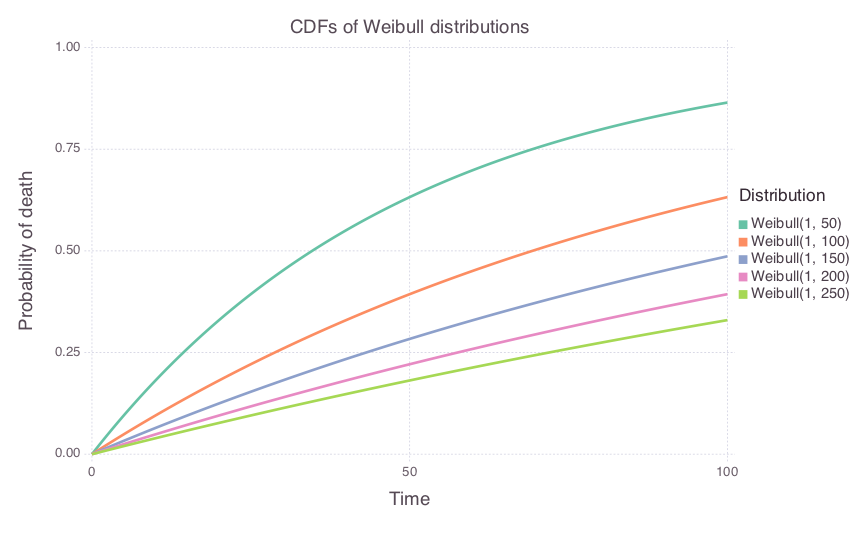

In [10]:
weibDistr = plot(
    [x->cdf(Weibull(1, i), x) for i in 50:50:250][:],
    color=["Weibull(1, $i)" for i in 50:50:250][:],
    0, 100,
    Guide.colorkey(title="Distribution"),
    Guide.xlabel("Time"),
    Guide.ylabel("Probability of death"),
    Guide.title("CDFs of Weibull distributions"),
    Scale.color_discrete_manual(gen_brew_colors(5)...),
    style(line_width=2pt, minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            colorkey_swatch_shape=:square))

For general information about the Weibull distribution, execute

In [11]:
?Weibull

search: Weibull



```
Weibull(α,θ)
```

The *Weibull distribution* with shape `α` and scale `θ` has probability density function

$$
f(x; \alpha, \theta) = \frac{\alpha}{\theta} \left( \frac{x}{\theta} \right)^{\alpha-1} e^{-(x/\theta)^\alpha},
    \quad x \ge 0
$$

```julia
Weibull()        # Weibull distribution with unit shape and unit scale, i.e. Weibull(1, 1)
Weibull(a)       # Weibull distribution with shape a and unit scale, i.e. Weibull(a, 1)
Weibull(a, b)    # Weibull distribution with shape a and scale b

params(d)        # Get the parameters, i.e. (a, b)
shape(d)         # Get the shape parameter, i.e. a
scale(d)         # Get the scale parameter, i.e. b
```

External links

  * [Weibull distribution on Wikipedia](http://en.wikipedia.org/wiki/Weibull_distribution)


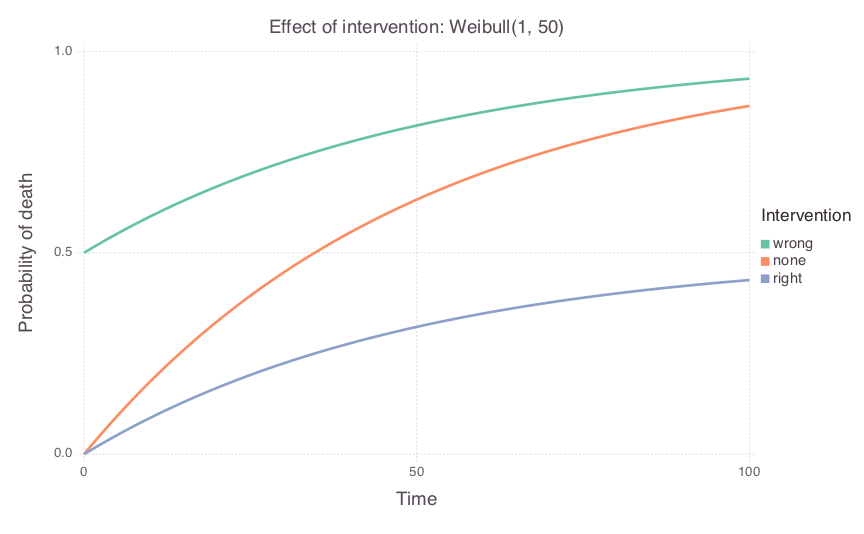

In [12]:
weibInter = plot(
    [x->(1 + cdf(Weibull(1, 50), x))/2,
     x->cdf(Weibull(1, 50), x),
     x->cdf(Weibull(1, 50), x)/2,
     ],
    color=["wrong", "none", "right"],
    0, 100,
    Guide.colorkey(title="Intervention"),
    Guide.xlabel("Time"),
    Guide.ylabel("Probability of death"),
    Guide.title("Effect of intervention: Weibull(1, 50)"),
    Scale.color_discrete_manual(gen_brew_colors(3)...),
    style(line_width=2pt, minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            colorkey_swatch_shape=:square))

### Running the simulations

In [13]:
@everywhere const numb_agents = 200
@everywhere const numb_generations = 100

In [14]:
# starting position: 50 Bayesians, and 50 agents per other group (EXPL, Good's rule, Popper's rule), with varying values for c (varying between 0 and 0.25)
@everywhere const numb_agents = 200
groupID = repeat(1.0:4.0, inner=div(numb_agents, 4))
population_start = vcat(fill(0, div(numb_agents, 4)), rand(Uniform(0, .25), 3*div(numb_agents, 4)))
pop_start = Array{Float32, 2}(hcat(groupID, population_start));

In [15]:
@everywhere function survWei(upds::Array{Float32, 2}, # modeling probability of death, based on Weibull distribution
                             hyp::Int64,
                             a::Float64, 
                             b::Float64,
                             shape::Float64=rand(Uniform(.5, 5)), 
                             scale::Float64=rand(Uniform(50, 250)), 
                             thresh::Float64=.9)
    
    t::Int64 = findfirst(upds .> thresh) # where in the matrix with probability updates do we find the first value above thresh?
    c::Int64 = cld(t, numb_toss + 1) # in which column is it?
    p::Int64 = t - (c - 1) * (numb_toss + 1) # in which row is it? (at which time does it occur?)
    
    # cdf(Weibull(shape, scale), p) below gives the probability of death at the relevant time

    if c == hyp
        1 - (cdf(Weibull(shape, scale), p) / a) # probability goes down if right intervention is made (which is made when the truth is assigned a probability above thresh)
    elseif c == 0
        1 - cdf(Weibull(shape, scale), numb_toss + 1) # if no intervention is made, output survival probability at last time step
    else
        (1 + (b - 1) * cdf(Weibull(shape, scale), p)) / b # probability goes down if wrong intervention is made (which happens if a false hypothesis is assigned a probabilty above thresh)
    end
end

In [16]:
@everywhere function patient(rule_index::Float32, c_value::Float32)

    rand_hyp::Int64 = rand(1:11) # pick α hypothesis ("what's wrong with the patient")
    right = rand(Uniform(1, 10)) # effect of right intervention
    wrong = rand(Uniform(1, 10)) # effect of wrong intervention

    @fastmath @inbounds data::Array{Bool, 1} = datFunc((rand_hyp - 1) / (numb_hyp - 1)) # generate synthetic data for this pick (the test results for the patient)
    
    updates = Array{Float32}(numb_toss + 1, numb_hyp) # initialize array for probabilities

    updates[1, :] = prior # set prior

    if rule_index == 1.0f0
        @fastmath @inbounds for t in 1:numb_toss # generate updates
            updates[t + 1, :] = b_upd(updates[t, :], data, t)
        end
    elseif rule_index == 2.0f0
        @fastmath @inbounds for t in 1:numb_toss # generate updates
            updates[t + 1, :] = expl_upd(updates[t, :], data, t, c_value)
        end
    elseif rule_index == 3.0f0
        @fastmath @inbounds for t in 1:numb_toss # generate updates
            updates[t + 1, :] = good_upd(updates[t, :], data, t, c_value)
        end
    else
        @fastmath @inbounds for t in 1:numb_toss # generate updates
            updates[t + 1, :] = pop_upd(updates[t, :], data, t, c_value)
        end
    end

    @fastmath @inbounds return survWei(updates, rand_hyp, right, wrong)
    
end

In [17]:
#= tests doctor on 100 patients and calculates average survival score obtained by doctor, so
average probability that patients would survive =#
@everywhere @fastmath @inbounds function avScore(rule_index::Float32, c_value::Float32)
    tot = @parallel (+) for i in 1:100
        patient(rule_index, c_value)
    end
    return tot / 100
end

In [18]:
#= tests all doctors in a population and selects the 50 percent fittest; outputs those
as well as a copy of each of them =#
function population_upd_rep(pop::Array{Float32, 2})

    agent_scores = SharedArray{Float32, 1}(numb_agents)

    @sync @parallel for i in 1:numb_agents
        @inbounds @fastmath agent_scores[i] = avScore((pop[i, :])...)
    end

    best_index = find(agent_scores .> median(agent_scores))

    best = pop[best_index, :]

    return vcat(best, best), agent_scores

end

population_upd_rep (generic function with 1 method)

In [19]:
#= runs the foregoing function for 100 generations (together with the starting population,
we have 101 generations in total), registering for each generation all relevant agent properties,
so the type the doctor belongs to, the bonus value attributed by the doctor, as well as the doctor's
fitness score =#
pop_upd_c_a = Array{Float32, 3}(numb_agents, 2, numb_generations + 1)
pop_upd_f = Array{Float32, 2}(numb_agents, numb_generations + 1)

pop_upd_c_a[:, :, 1] = pop_start

@fastmath @inbounds for i in 1:numb_generations
    pop_upd_c_a[:, :, i + 1], pop_upd_f[:, i] = population_upd_rep(pop_upd_c_a[:, :, i])
end

@fastmath @inbounds for i in 1:numb_agents
    pop_upd_f[i, numb_generations + 1] = avScore((pop_upd_c_a[i, 1:2, numb_generations + 1])...)
end

In [20]:
# extracts agent type and bonus values, for easy separate storage
res_a = Array{Int32, 2}(numb_agents, numb_generations + 1)
res_c = Array{Float32, 2}(numb_agents, numb_generations + 1)

for i in 1:numb_generations + 1
     res_a[:, i], res_c[:, i] = pop_upd_c_a[:, 1, i], pop_upd_c_a[:, 2, i]
end

In [21]:
#= stores the relevant data for all generations (assumes a folder 'data' in the directory in which this notebook
is stored) =#
writedlm("data/weib_agent_type1.txt", res_a)
writedlm("data/weib_c_value1.txt", res_c)
writedlm("data/weib_fit1.txt", pop_upd_f)

The above allows running one simulation at a time, the relevant output of which can then be stored. The block of code below runs 100 simulations and stores the relevant output of each. Depending on the computer used, this can lead to memory problems. It did on my computer. Running smaller batches of simulations (e.g., 20 per run) at a time did work, however. 

In [ ]:
k = 1
while k < 101
    groupID = repeat(1.0:4.0, inner=div(numb_agents, 4))
    population_start = vcat(fill(0, div(numb_agents, 4)), rand(Uniform(0, .25), 3*div(numb_agents, 4)))
    pop_start = Array{Float32, 2}(hcat(groupID, population_start))
    pop_upd_c_a = Array{Float32, 3}(numb_agents, 2, numb_generations + 1)
    pop_upd_f = Array{Float32, 2}(numb_agents, numb_generations + 1)
    pop_upd_c_a[:, :, 1] = pop_start

    @fastmath @inbounds for i in 1:numb_generations
        pop_upd_c_a[:, :, i + 1], pop_upd_f[:, i] = population_upd_rep(pop_upd_c_a[:, :, i])
    end

    @fastmath @inbounds for i in 1:numb_agents
        pop_upd_f[i, numb_generations + 1] = avScore((pop_upd_c_a[i, 1:2, numb_generations + 1])...)
    end

    res_a = Array{Int32, 2}(numb_agents, numb_generations + 1)
    res_c = Array{Float32, 2}(numb_agents, numb_generations + 1)

    for i in 1:(numb_generations + 1)
        res_a[:, i], res_c[:, i] = pop_upd_c_a[:, 1, i], pop_upd_c_a[:, 2, i]
    end

    writedlm("data/weib_agent_type$k.txt", res_a) # here too, create a folder 'data' in the relevant directory
    writedlm("data/weib_c_value$k.txt", res_c)
    writedlm("data/weib_fit$k.txt", pop_upd_f)

    population_start = nothing
    pop_start = nothing
    pop_upd_c_a = nothing
    pop_upd_f = nothing
    res_a = nothing
    res_c = nothing
    gc()
end

### Plot counts of types per generation for one simulation

In [22]:
fullType = readdlm("data/weib_agent_type1.txt");

In [23]:
ks = [keys(sort(countmap(fullType[:,i]))) for i in 1:numb_generations + 1]
vls = [values(sort(countmap(fullType[:,i]))) for i in 1:numb_generations + 1]

group = []
freq = []
gen = []

for i in 1:101
    append!(group, collect(ks[i]))
    append!(freq, collect(vls[i]))
    append!(gen, fill(i, length(collect(ks[i]))))
end

bar_df = convert(DataFrame, hcat(group, freq, gen))

bar_df[:x4] = map(bar_df[:x1]) do x
    if x == 1
        return "Bayes"
    elseif x == 2
        return "EXPL"
    elseif x == 3
        return "Good"
    else
        return "Popper"
    end
end

names!(bar_df, [Symbol("$i") for i in ["Group", "Count", "Generation", "Rule"]]);

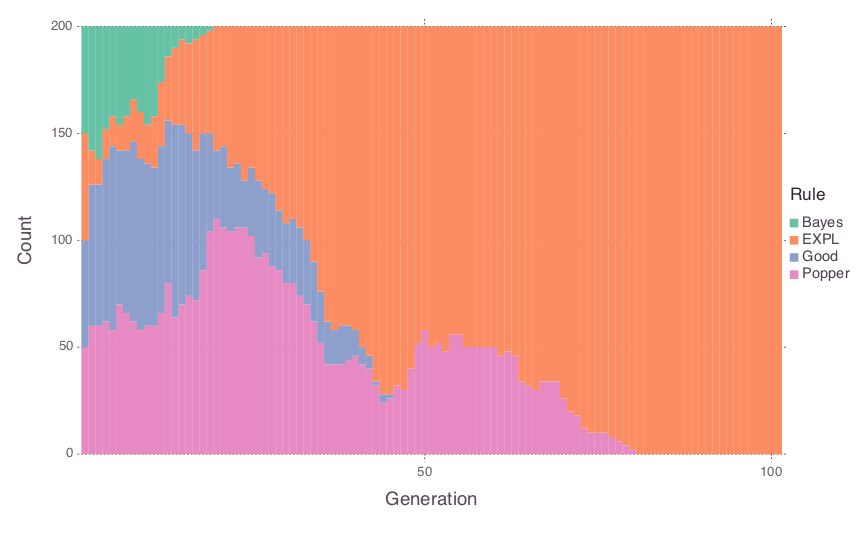

In [24]:
plot(bar_df, x=:Generation, y=:Count, color=:Rule, Geom.bar(position=:stack),
    Coord.cartesian(xmin=1, xmax=numb_generations + 1),
    Guide.colorkey(title="Rule"),
    Scale.color_discrete_manual(gen_brew_colors(4)...),
    style(minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            grid_color=colorant"#222831",
            colorkey_swatch_shape=:square))

### Visualize full results

In [25]:
full_results_type = Array{Int32, 3}(200, 101, 100)

for i in 1:100
    full_results_type[:, :, i] = readdlm("data/weib_agent_type$i.txt")
end

In [26]:
percentages = Array{Float64, 3}(100, 101, 4)

for k in 1:4
    for j in 1:101
        percentages[:, j, k] = [ length(find(full_results_type[:, j, i] .== k)) / 200 for i in 1:100 ]
    end
end

In [27]:
@everywhere function bs(x, n=1000)
    bootstrap(x, mean, BasicSampling(n))
end

bayesBoot = SharedArray{Float64}(101, 3);
    
@parallel for i in 1:101
    bayesBoot[i, :] = [Bootstrap.ci(bs(percentages[:, i, 1]), BasicConfInt(.95))[1]...]
end

explBoot = SharedArray{Float64}(101, 3);
    
@parallel for i in 1:101
    explBoot[i, :] = [Bootstrap.ci(bs(percentages[:, i, 2]), BasicConfInt(.95))[1]...]
end

goodBoot = SharedArray{Float64}(101, 3);
    
@parallel for i in 1:101
    goodBoot[i, :] = [Bootstrap.ci(bs(percentages[:, i, 3]), BasicConfInt(.95))[1]...]
end

popperBoot = SharedArray{Float64}(101, 3);
    
@parallel for i in 1:101
    popperBoot[i, :] = [Bootstrap.ci(bs(percentages[:, i, 4]), BasicConfInt(.95))[1]...]
end

3-element Array{Future,1}:
 Future(2, 1, 2017, #NULL)
 Future(3, 1, 2018, #NULL)
 Future(4, 1, 2019, #NULL)

In [28]:
Generation = repeat(collect(1:101), outer=4)
Rule = repeat(["Bayes", "EXPL", "Good", "Popper"], inner=101)
type_df = convert(DataFrame, hcat(vcat(bayesBoot, explBoot, goodBoot, popperBoot), Generation, Rule))
names!(type_df, [Symbol("$i") for i in ["y", "ymin", "ymax", "Generation", "Rule"]]);

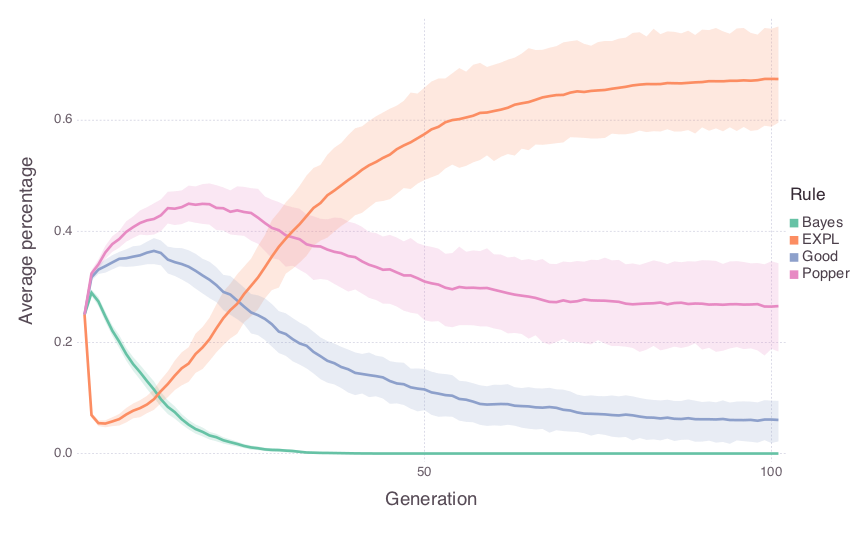

In [29]:
plot(type_df, x=:Generation, y=:y, ymin=:ymin, ymax=:ymax, color=:Rule, Geom.line, Geom.ribbon,
    Guide.ylabel("Average percentage"),
    Coord.cartesian(xmin=1, xmax=101, ymin=-.001),
    Scale.color_discrete_manual(gen_brew_colors(4)...),
    style(line_width=2pt, lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2),
            minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            colorkey_swatch_shape=:square))

We do the same for the bonus values.

In [30]:
full_results_c = Array{Float32, 3}(200, 101, 100)

for i in 1:100
    full_results_c[:, :, i] = readdlm("data/weib_c_value$i.txt")
end

In [31]:
expl_c_res = Array{Float64, 2}(101, 3)

for k in 1:101
    cr = Float64[]
    for j in 1:100
        push!(cr, mean([ full_results_c[:, k, i][(full_results_type[:, k, i] .== 2)] for i in 1:100 ][j]))
    end
    cr = cr[.!isnan.(cr)]
    expl_c_res[k, :] = vcat(mean(cr), [confint(OneSampleTTest(cr))...])
end

good_c_res = Array{Float64, 2}(101, 3)

for k in 1:101
    cr = Float64[]
    for j in 1:100
        push!(cr, mean([ full_results_c[:, k, i][(full_results_type[:, k, i] .== 3)] for i in 1:100 ][j]))
    end
    cr = cr[.!isnan.(cr)]
    good_c_res[k, :] = vcat(mean(cr), [confint(OneSampleTTest(cr))...])
end

pop_c_res = Array{Float64, 2}(101, 3)

for k in 1:101
    cr = Float64[]
    for j in 1:100
        push!(cr, mean([ full_results_c[:, k, i][(full_results_type[:, k, i] .== 4)] for i in 1:100 ][j]))
    end
    cr = cr[.!isnan.(cr)]
    pop_c_res[k, :] = vcat(mean(cr), [confint(OneSampleTTest(cr))...])
end

In [32]:
Generation = repeat(collect(1:101), outer=3)
Rule = repeat(["EXPL", "Good", "Popper"], inner=101)
cval_df = convert(DataFrame, hcat(vcat(expl_c_res, good_c_res, pop_c_res), Generation, Rule))
names!(cval_df, [Symbol("$i") for i in ["y", "ymin", "ymax", "Generation", "Rule"]]);

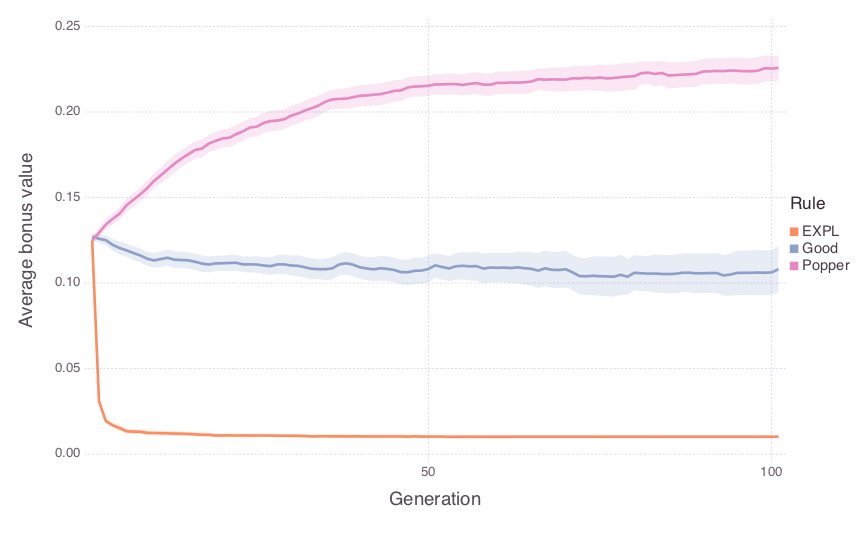

In [33]:
plot(cval_df, x=:Generation, y=:y, ymin=:ymin, ymax=:ymax, color=:Rule, Geom.line, Geom.ribbon,
    Guide.ylabel("Average bonus value"),
    Coord.cartesian(xmin=1, xmax=101),
    Scale.color_discrete_manual(gen_brew_colors(4)[2:4]...),
    style(line_width=2pt, lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2),
            minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            colorkey_swatch_shape=:square))

Now the same for the fitness of the agents.

In [34]:
full_results_f = Array{Float32, 3}(200, 101, 100)

for i in 1:100
    full_results_f[:, :, i] = readdlm("data/weib_fit$i.txt")
end

In [35]:
bayes_f_res = Array{Float64, 2}(101, 3)

for k in 1:101
    cr = Float64[]
    for j in 1:100
        push!(cr, mean([ full_results_f[:, k, i][(full_results_type[:, k, i] .== 1)] for i in 1:100 ][j]))
    end
    cr = cr[.!isnan.(cr)]
    bayes_f_res[k, :] = length(unique(cr)) > 1 ? vcat(mean(cr), [confint(OneSampleTTest(cr))...]) : [NaN, NaN, NaN]
end

expl_f_res = Array{Float64, 2}(101, 3)

for k in 1:101
    cr = Float64[]
    for j in 1:100
        push!(cr, mean([ full_results_f[:, k, i][(full_results_type[:, k, i] .== 2)] for i in 1:100 ][j]))
    end
    cr = cr[.!isnan.(cr)]
    expl_f_res[k, :] = length(unique(cr)) > 1 ? vcat(mean(cr), [confint(OneSampleTTest(cr))...]) : [NaN, NaN, NaN]
end

good_f_res = Array{Float64, 2}(101, 3)

for k in 1:101
    cr = Float64[]
    for j in 1:100
        push!(cr, mean([ full_results_f[:, k, i][(full_results_type[:, k, i] .== 3)] for i in 1:100 ][j]))
    end
    cr = cr[.!isnan.(cr)]
    good_f_res[k, :] = length(unique(cr)) > 1 ? vcat(mean(cr), [confint(OneSampleTTest(cr))...]) : [NaN, NaN, NaN]
end

pop_f_res = Array{Float64, 2}(101, 3)

for k in 1:101
    cr = Float64[]
    for j in 1:100
        push!(cr, mean([ full_results_f[:, k, i][(full_results_type[:, k, i] .== 4)] for i in 1:100 ][j]))
    end
    cr = cr[.!isnan.(cr)]
    pop_f_res[k, :] = length(unique(cr)) > 1 ? vcat(mean(cr), [confint(OneSampleTTest(cr))...]) : [NaN, NaN, NaN]
end

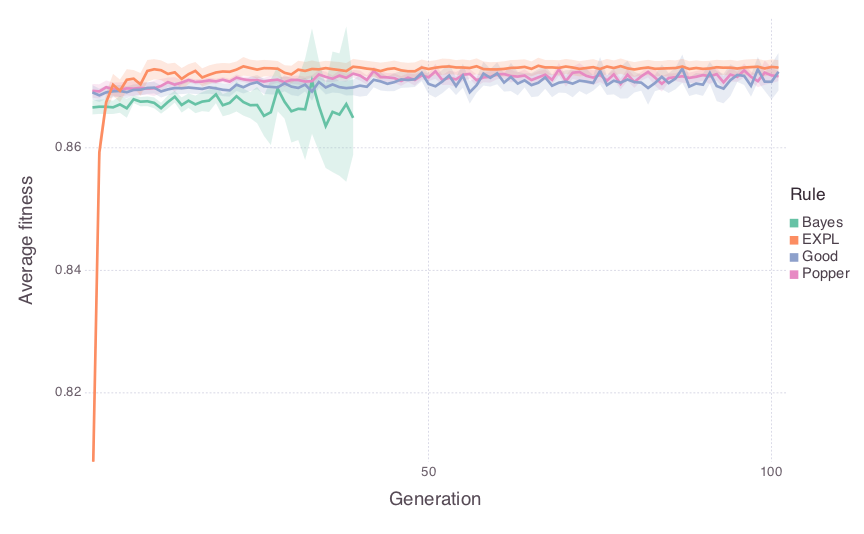

In [36]:
plot(
    layer(x=1:101,
    y=expl_f_res[1:101, 1],
    Geom.line,
    Theme(default_color=colorant"#fc8d62", line_width=2pt)
    ),
    layer(x=1:101,
    y=good_f_res[1:101, 1],
    Geom.line,
    Theme(default_color=colorant"#8da0cb", line_width=2pt)
    ),
    layer(x=1:101,
    y=pop_f_res[1:101, 1],
    Geom.line,
    Theme(default_color=colorant"#e78ac3", line_width=2pt)
    ),
    layer(x=1:39,
    y=bayes_f_res[1:39, 1],
    ymin=bayes_f_res[1:39, 2],
    ymax=bayes_f_res[1:39, 3],
    Geom.line,
    Geom.ribbon,
    Theme(default_color=colorant"#66c2a5", line_width=2pt, lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2))
    ),
    layer(x=1:101,
    y=expl_f_res[1:101, 1],
    ymin=expl_f_res[1:101, 2],
    ymax=expl_f_res[1:101, 3],
    Geom.line,
    Geom.ribbon,
    Theme(default_color=colorant"#fc8d62", lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2))
    ),
    layer(x=1:101,
    y=good_f_res[1:101, 1],
    ymin=good_f_res[1:101, 2],
    ymax=good_f_res[1:101, 3],
    Geom.line,
    Geom.ribbon,
    Theme(default_color=colorant"#8da0cb", lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2))
    ),
    layer(x=1:101,
    y=pop_f_res[1:101, 1],
    ymin=pop_f_res[1:101, 2],
    ymax=pop_f_res[1:101, 3],
    Geom.line,
    Geom.ribbon,
    Theme(default_color=colorant"#e78ac3", lowlight_color=c->RGBA{Float32}(c.r, c.g, c.b, 0.2))
    ),
    Guide.xlabel("Generation"),
    Guide.ylabel("Average fitness"),
    Coord.cartesian(xmax=101, ymin=.81),
    Guide.manual_color_key("Rule", ["Bayes", "EXPL", "Good", "Popper"], ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3"]),
    style(minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            colorkey_swatch_shape=:square))

### Summary information about last generations

In [37]:
sum([ sum((full_results_type[:, 101, i] .== 2)) for i in 1:100 ]), sum([ sum((full_results_type[:, 101, i] .== 3)) for i in 1:100 ]), sum([ sum((full_results_type[:, 101, i] .== 4)) for i in 1:100 ])

(13482, 1210, 5308)

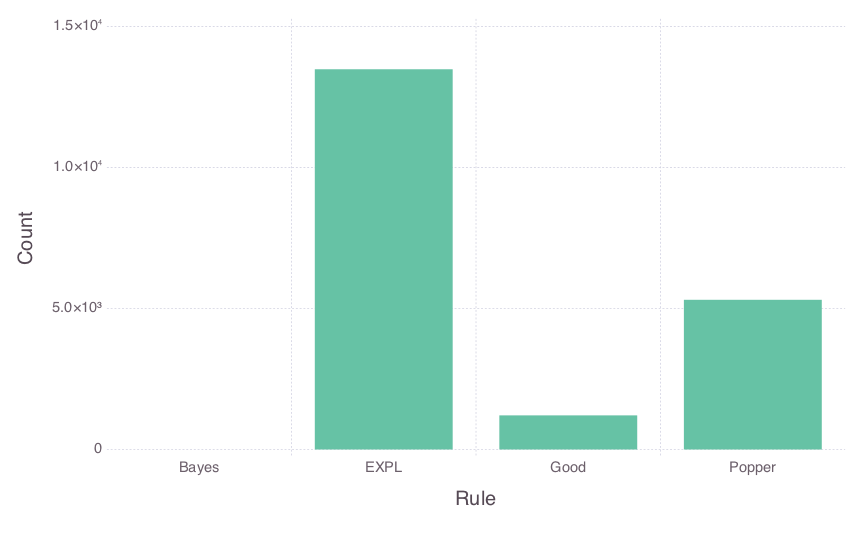

In [38]:
plot(x = ["Bayes", "EXPL", "Good", "Popper"], y = [0, 13482, 1210, 5308], Geom.bar,
    Guide.xlabel("Rule"),
    Guide.ylabel("Count"),
    Scale.x_discrete,
    style(default_color=colorant"#66c2a5", minor_label_font_size=11pt, major_label_font_size=15pt,
            bar_spacing=35pt))

In [39]:
lastE = Float64[]
for j in 1:100
    append!(lastE, [ full_results_c[:, 101, i][(full_results_type[:, 101, i] .== 2)] for i in 1:100 ][j])
end

lastG = Float64[]
for j in 1:100
    append!(lastG, [ full_results_c[:, 101, i][(full_results_type[:, 101, i] .== 3)] for i in 1:100 ][j])
end

lastP = Float64[]
for j in 1:100
    append!(lastP, [ full_results_c[:, 101, i][(full_results_type[:, 101, i] .== 4)] for i in 1:100 ][j])
end

In [40]:
df = DataFrame(Rule = vcat(fill("EXPL", length(lastE)), fill("Good", length(lastG)), fill("Popper", length(lastP))), C_value = vcat(lastE, lastG, lastP));

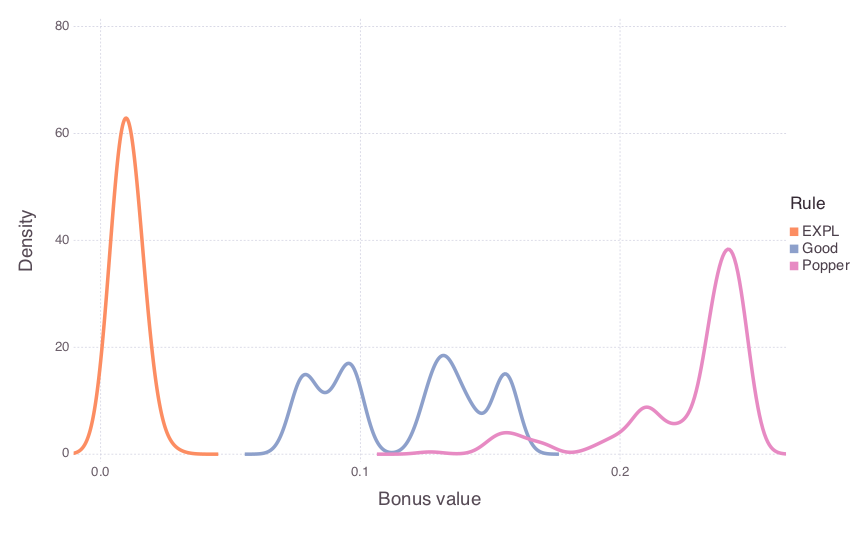

In [41]:
plot(df, x=:C_value, color=:Rule, Geom.density(bandwidth=.005),
     Coord.cartesian(xmin=-.0075, xmax=.261),
     Scale.color_discrete_manual(gen_brew_colors(4)[2:4]...),
     Guide.xlabel("Bonus value"),
     Guide.ylabel("Density"),
     style(line_width=2.65pt, minor_label_font_size=10pt, major_label_font_size=14pt,
            key_label_font_size=11pt, key_title_font_size=13pt,
            colorkey_swatch_shape=:square))

### Statistics

In [43]:
using RCall

In [44]:
lastEF = Float64[]
for j in 1:100
    append!(lastEF, [ full_results_f[:, 101, i][(full_results_type[:, 101, i] .== 2)] for i in 1:100 ][j])
end

lastGF = Float64[]
for j in 1:100
    append!(lastGF, [ full_results_f[:, 101, i][(full_results_type[:, 101, i] .== 3)] for i in 1:100 ][j])
end

lastPF = Float64[]
for j in 1:100
    append!(lastPF, [ full_results_f[:, 101, i][(full_results_type[:, 101, i] .== 4)] for i in 1:100 ][j])
end

In [45]:
x = vcat(lastEF, lastGF, lastPF)
y = vcat(fill("EXPL", length(lastEF)), fill("Good", length(lastGF)), fill("Popper", length(lastPF)))
R"summary(aov($x ~ $y))"

RCall.RObject{RCall.VecSxp}
               Df Sum Sq  Mean Sq F value   Pr(>F)    
`#JL`$y         2  0.012 0.006086   18.22 1.24e-08 ***
Residuals   19997  6.678 0.000334                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [46]:
R"pairwise.t.test($x, $y, p.adj = 'bonf')"

RCall.RObject{RCall.VecSxp}

	Pairwise comparisons using t tests with pooled SD 

data:  `#JL`$x and `#JL`$y 

       EXPL    Good
Good   4.7e-05 -   
Popper 4.2e-06 0.32

P value adjustment method: bonferroni 


In [47]:
R"library(lsr)"
R"eSq <- etaSquared(aov($x ~ $y))[1]"

RCall.RObject{RCall.RealSxp}
[1] 0.001819182


In [49]:
R"library(emmeans)"
R"df <- data.frame(x = $x, y = $y)"
R"mod <- lm(x ~ y, data = df)"
R"emmeans(mod, ~ y)"

RCall.RObject{RCall.S4Sxp}
 y         emmean           SE    df  lower.CL  upper.CL
 EXPL   0.8731169 0.0001573905 19997 0.8728084 0.8734254
 Good   0.8707472 0.0005253673 19997 0.8697174 0.8717769
 Popper 0.8716879 0.0002508362 19997 0.8711963 0.8721796

Confidence level used: 0.95 


In [50]:
x1 = vcat(lastE, lastG, lastP)
y1 = vcat(fill("EXPL", length(lastE)), fill("Good", length(lastG)), fill("Popper", length(lastP)))
R"df <- data.frame(x = $x1, y = $y1)"
R"mod <- lm(x ~ y, data = df)"
R"emmeans(mod, ~ y)"

RCall.RObject{RCall.S4Sxp}
 y          emmean           SE    df   lower.CL   upper.CL
 EXPL   0.01024819 0.0001346443 19997 0.00998428 0.01051211
 Good   0.11699026 0.0004494408 19997 0.11610932 0.11787121
 Popper 0.22648989 0.0002145852 19997 0.22606929 0.22691050

Confidence level used: 0.95 
